# МОиВС "Генеративные модели", 5-й модуль

# Homework 1

В этой домашней работе вам предстоит добавить к BERT'у декодерную часть и решить задачу генерации суммаризаций для текстов новостей на русском языке.

Дополнительно к этому на отличную оценку потребуется реализовать подсчет метрик качества и менее жадную стратегию выбора следующего токена для генерации.

*Мы сразу вас предостерегаем попасть в петлю бесконечного дообучения модели. Эта домашка не на пробитие скора. Мы будем проверять, что вы, в целом, сделали все верно и смогли получить какую-то более-менее адекватную (такую, которая заметно лучше той, что была до начала обучения) генерацию. Таким образом, если вы видите, что модель учится, не надо дообучать её сутками. Нескольких часов точно должно хватить.*



---


---
По любым вопросам касательно этой домашней работы обращайтесь ко своим ассистентам




Под линукс:

In [1]:
%%bash
pip install transformers datasets evaluate

<3>WSL (11) ERROR: CreateProcessEntryCommon:505: execvpe /bin/bash failed 2
<3>WSL (11) ERROR: CreateProcessEntryCommon:508: Create process not expected to return


CalledProcessError: Command 'b'pip install transformers datasets evaluate\n'' returned non-zero exit status 1.

Для винды:

In [1]:
!pip install transformers datasets evaluate
!pip install --upgrade torch 

In [1]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AutoTokenizer

## Подготовка данных (0.5 балла)

Мы воспользуемся датасетом с 🤗 Ильи Гусева "gazeta". Он представляет собой пары (полный текст новости -- его саммари). Пары были взяты с одноименного сайта в домене .ru

Более подробно про датасет можно прочитать [здесь](https://huggingface.co/datasets/IlyaGusev/gazeta)



In [2]:
# Отключаем предупреждения
import os

os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [4]:
# Загрузим данные с помощью библиотеки datasets

from datasets import load_dataset
dataset = load_dataset('IlyaGusev/gazeta', revision="v2.0", split='train[:5%]', trust_remote_code=True)

Вы должны помнить, что тексты перед подачей в модель необходимо **токенизировать**.

Добавьте паддинг до `max_length=512` для обучающих данных, а также до `max_length=128` для меток.

Используйте обрезку текстов, длина которых в токенах превышает `max_length`

In [7]:
# Подготовим данные для модели Bert

model_name = 'deepvk/bert-base-uncased' # Указание модели BERT

tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(examples, max_lengths=[512, 128], text_columns=["text", "summary"], tokenize_tag="_tokenized"):
    model_inputs = {}
    for i in range(len(text_columns)):
      model_inputs[text_columns[i] + tokenize_tag] = tokenizer(examples[text_columns[i]],
                                                   padding='max_length',
                                                   truncation=True,
                                                   max_length=max_lengths[i])

    return model_inputs

In [8]:
tokenized_dataset = dataset.map(preprocess, batched=False)
tokenized_dataset.set_format('torch')

Размер батча советуем подбирать таким образом, чтоб утилизировать максимум доступной VRAM

In [9]:
from torch.utils.data import DataLoader

split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset, test_dataset = split_dataset["train"], split_dataset["test"]

print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер тестовой выборки: {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8) # Под 8гб видеопамяти видеокарты
eval_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=8)


Размер обучающей выборки: 2438
Размер тестовой выборки: 610


## Реализация Decoder-cети (3 балла)

В данном разделе вам необходимо **реализовать собственный декодер для генерации текста**.

Можете вдохновляться кодом с семинара 1 по GPT. В инициализации весов стоит (но необязательно) проявить смекалку

In [10]:
class Head(nn.Module):
    """ Голова self-attention """

    def __init__(self, n_embd, head_size, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # нижнетреугольная матрица для маскировки
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, x_mask):

        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        # расчет affinities
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    """ Несколько голов self-attention, запараллеленных """

    def __init__(self, n_embd, num_heads, head_size, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embd, head_size, block_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, x_mask):
        out = torch.cat([h(x, x_mask) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class EncDecHead(nn.Module):
    """ Голова self-attention энкодера-декодера """

    def __init__(self, n_embd, head_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask):

        k = self.key(memory)
        q = self.query(tgt)
        # расчет affinities
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(tgt_mask, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(memory)
        out = wei @ v
        return out

class EncDecMultiHeadAttention(nn.Module):
    """ Несколько голов self-attention, запараллеленных """

    def __init__(self, n_embd, num_heads, head_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([EncDecHead(n_embd, head_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask):
        out = torch.cat([h(tgt, memory, tgt_mask) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ Простая линейная сеть с нелинейностью """

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Блок трансформера """

    def __init__(self, n_embd, num_heads, block_size, dropout):
        
        super().__init__()
        head_size = n_embd // num_heads
        self.encdecsa = EncDecMultiHeadAttention(n_embd, num_heads, head_size, dropout)
        self.sa = MultiHeadAttention(n_embd, num_heads, head_size, block_size, dropout)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, tgt, memory, tgt_mask):
        x = tgt + self.sa(tgt, tgt_mask)
        x = x + self.encdecsa(self.ln1(x), memory, tgt_mask)
        x = x + self.ffwd(self.ln2(x))
        return x

In [11]:
import torch
import torch.nn as nn
from transformers import BertModel
from torch.nn import functional as F

# Класс модели для суммаризации на основе BERT с кастомным декодером

class BertDecoder(nn.Module):
    def __init__(self,
                 hidden_size=768,
                 num_decoder_layers=3,
                 num_heads=8,
                 dropout=0.1,
                 block_size=128):
        super(BertDecoder, self).__init__()

        self.position_embedding_table = nn.Embedding(block_size, hidden_size)
        self.decoder_layers = nn.ModuleList([Block(n_embd=hidden_size, num_heads=num_heads, block_size=block_size, dropout=dropout) for _ in range(num_decoder_layers)])
        self.ln_f = nn.LayerNorm(hidden_size)

    def forward(self, tgt, memory, tgt_mask):
        # Добавляем позиционные эмбеддинги к токенам декодера
        pos_emb = self.position_embedding_table(torch.arange(tgt.size(1), device=tgt.device)) # (T,C)
        tgt = tgt + pos_emb # (B, T, C)
        # Прогоняем через каждый слой декодера
        for layer in self.decoder_layers:
            tgt = layer(tgt, memory, tgt_mask)
        output = self.ln_f(tgt)  # Нормализация слоя
        return output

class BertSummarizer(nn.Module):
    def __init__(self,
                bert_model_name='bert-base-uncased',
                hidden_size=768,
                num_decoder_layers=3,
                num_heads=8,
                dropout=0.1,
                encoder_block_size=512,
                summary_block_size=128):
        super(BertSummarizer, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.hidden_size = hidden_size
        self.encoder_block_size = encoder_block_size
        self.summary_block_size = summary_block_size
        # Эмбеддинги для токенов на входе в декодер
        self.embedding = nn.Embedding(self.bert.config.vocab_size, hidden_size)
        self.register_buffer('tril', torch.tril(torch.ones(summary_block_size, encoder_block_size)))
        self.decoder = BertDecoder(hidden_size=hidden_size, num_decoder_layers=num_decoder_layers,
        num_heads=num_heads, dropout=dropout, block_size=summary_block_size)
        self.fc_out = nn.Linear(hidden_size, self.bert.config.vocab_size)
        self.softmax = nn.Softmax(dim=-1)

    # Функция для создания маски для предотвращения заглядывания вперед в декодере
    def generate_square_subsequent_mask(self, T):
        return self.tril[:T, :self.encoder_block_size] == 0

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        # Получаем выходные данные из BERT-энкодера
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        memory = encoder_outputs.last_hidden_state
        embedded = self.embedding(decoder_input_ids)
        tgt_mask = self.generate_square_subsequent_mask(embedded.size(1)).to(input_ids.device)
        # Прогоняем данные через кастомный декодер
        decoder_output = self.decoder(tgt=embedded, memory=memory, tgt_mask=tgt_mask)
        # Применяем линейную проекцию для получения логитов токенов
        output = self.fc_out(decoder_output)
        return output

    def generate(self, input_ids, attention_mask, tokenizer, max_len=50):
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        memory = encoder_outputs.last_hidden_state
        batch_size = input_ids.size(0)

        # Инициализируем последовательность с токеном [CLS] или [BOS]
        decoder_input_ids = torch.full((batch_size, 1), tokenizer.cls_token_id, dtype=torch.long).to(input_ids.device)
        eos_id = tokenizer.sep_token_id

        for _ in range(max_len):
            embedded = self.embedding(decoder_input_ids)

            # Генерация маски для предотвращения заглядывания вперед
            decoder_attention_mask = self.generate_square_subsequent_mask(embedded.size(1)).to(input_ids.device)
            decoder_output = self.decoder(tgt=embedded, memory=memory, tgt_mask=decoder_attention_mask)
            # Получаем логиты токенов и вычисляем вероятности
            output = self.fc_out(decoder_output)
            output_probs = F.softmax(output[:, -1, :], dim=-1)
            # Выбираем следующий токен на основе вероятностей и добавляем в последовательность
            next_token = torch.multinomial(output_probs, num_samples=1)
            decoder_input_ids = torch.cat([decoder_input_ids, next_token], dim=1)

            # Проверка, был ли предсказан EOS токен
            if next_token.item() == eos_id:
                break
                
            # Получаем индекс токена с наибольшей вероятностью.
            # Помните, если EOS предсказан, прекращаем генерацию
        generated_sequence = tokenizer.decode(decoder_input_ids.squeeze().tolist(), skip_special_tokens=True)

        return generated_sequence

In [10]:
# Инициализируем нашу модель и посморим на ее архитектруру

model = BertSummarizer(bert_model_name=model_name)
model = model.to('cuda') 
model

BertSummarizer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(36000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [11]:
# Посмотрим на генерацию без обучения

eval_data_sample = next(iter(eval_dataloader))
model.generate(eval_data_sample['text_tokenized']['input_ids'][:1].to('cuda'),eval_data_sample['text_tokenized']['attention_mask'][:1].to('cuda'), tokenizer)

C:\Users\pashv\PycharmProjects\Study\.venv\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


'##льному ##воды отдельным потянул ##хонь 🔥 круглосу спеша спирт мошенников ang консультант dota подожд грусти германия другои ##лья дед пиратка ##циеи приступ fest солнечного для реал ведьмы шанта ##жнои ##етесь явление жм ##рои забота красива разговаривал 30 поднял ##юк потомки лепест ?:) заставил закрыл ##от проигра продал общая вязания рак'

## Обучение модели (1 балл)

<small> 0.25 балла за простейший рабочий цикл; </small>

<small> +0.5 балла за графики для лосса и метрик на трейне и валидации.</small>

В данном разделе вам необходимо **реализовать цикл для обучения модели**


In [12]:
#для графика
!pip install seaborn

In [12]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def train_step(model, input_ids, attention_mask, decoder_input_ids, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask, decoder_input_ids[:, :-1])
    loss = criterion(outputs.view(-1, outputs.size(-1)), decoder_input_ids[:, 1:].reshape(-1))
    loss.backward()
    optimizer.step()
    
    return loss.item()

def validate(model, val_dataloader, criterion, tokenizer):
    device = next(model.parameters()).device
    model.eval()
    total_loss = 0

    # Отключаем градиенты для ускорения
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["text_tokenized"]["input_ids"].to(device)
            attention_mask = batch["text_tokenized"]["attention_mask"].to(device)
            decoder_input_ids = batch["summary_tokenized"]["input_ids"].to(device)

            outputs = model(input_ids, attention_mask, decoder_input_ids[:, :-1])
            loss = criterion(outputs.view(-1, outputs.size(-1)), decoder_input_ids[:, 1:].reshape(-1))
            total_loss += loss.item()

    # Пример сгенерированного резюме для наглядности и референса
    print("-" * 50)
    example_summary = model.generate(batch['text_tokenized']['input_ids'][:1].to(device),
                                      batch['text_tokenized']['attention_mask'][:1].to(device),
                                      tokenizer)
    
    reference_ids = batch['summary_tokenized']['input_ids'][:1]
    reference_summary = tokenizer.decode(reference_ids.squeeze().tolist(), skip_special_tokens=True)

    print("Generated Summary:\n", example_summary)
    print("Reference Summary:\n", reference_summary)
    print("-" * 50)
    
    return total_loss / len(val_dataloader)  # Средняя ошибка на валидационных данных

# Основная функция обучения модели
def train(model, num_epochs, optimizer, criterion, train_dataloader, val_dataloader, tokenizer):
    device = next(model.parameters()).device
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_dataloader, desc=f'Эпоха обучения {epoch + 1}/{num_epochs}', leave=False):
            input_ids = batch["text_tokenized"]["input_ids"].to(device)
            attention_mask = batch["text_tokenized"]["attention_mask"].to(device)
            decoder_input_ids = batch["summary_tokenized"]["input_ids"].to(device)

            loss = train_step(model, input_ids, attention_mask, decoder_input_ids, optimizer, criterion)
            total_train_loss += loss

        avg_train_loss = total_train_loss / len(train_dataloader)  # Средняя ошибка на трейне
        train_losses.append(avg_train_loss)

        val_loss = validate(model, val_dataloader, criterion, tokenizer)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs} - Train loss: {avg_train_loss:.4f} - Val loss: {val_loss:.4f}")

    # Построение графиков
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=range(1, num_epochs+1), y=train_losses, label="Train loss")
    sns.lineplot(x=range(1, num_epochs+1), y=val_losses, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Graph")
    plt.show()

## Метрики качества (1 балл)

<small>По 0.33 балла за реализацию каждой из предлагаемых метрик</small>

**Реализуйте функицию для подсчета метрик качества суммаризации.**

Докуметация по некотрым метрикам:
 1. [HuggingFace Rouge](https://huggingface.co/spaces/evaluate-metric/rouge)
 2. [HuggingFace Bleu](https://huggingface.co/spaces/evaluate-metric/bleu)
 3. [HuggingFace BERT Score](https://huggingface.co/spaces/evaluate-metric/bertscore)

In [14]:
!pip install --upgrade datasets
!pip install rouge_score absl-py
!pip install bert-score

In [13]:
import evaluate
import numpy as np
from collections import Counter

def compute_rouge(reference, generated, tokenizer):
    """ Вычисление метрики ROUGE с использованием кастомного токенайзера, f1-меры для ROUGE-1, ROUGE-2, ROUGE-L """
    
    # Токенизация текста с использованием токенайзера
    reference_tokens = tokenizer.tokenize(reference)
    candidate_tokens = tokenizer.tokenize(generated)

    # Создание счетчиков для подсчета n-грамм
    reference_counter = Counter(reference_tokens)
    candidate_counter = Counter(candidate_tokens)

    # Учет перекрытия токенов
    overlap = sum((candidate_counter & reference_counter).values())

    # ROUGE-1 (однограммы)
    precision_rouge1 = overlap / len(candidate_tokens) if candidate_tokens else 0
    recall_rouge1 = overlap / len(reference_tokens) if reference_tokens else 0
    f1_rouge1 = (2 * precision_rouge1 * recall_rouge1) / (precision_rouge1 + recall_rouge1) if (precision_rouge1 + recall_rouge1) else 0

    # ROUGE-2 (биграммы)
    candidate_bigrams = Counter(tuple(candidate_tokens[i:i+2]) for i in range(len(candidate_tokens)-1))
    reference_bigrams = Counter(tuple(reference_tokens[i:i+2]) for i in range(len(reference_tokens)-1))
    overlap_bigrams = sum((candidate_bigrams & reference_bigrams).values())
    
    precision_rouge2 = overlap_bigrams / len(candidate_bigrams) if candidate_bigrams else 0
    recall_rouge2 = overlap_bigrams / len(reference_bigrams) if reference_bigrams else 0
    f1_rouge2 = (2 * precision_rouge2 * recall_rouge2) / (precision_rouge2 + recall_rouge2) if (precision_rouge2 + recall_rouge2) else 0

    # ROUGE-L (Longest Common Subsequence - наибольшая общая подпоследовательность)
    def lcs(x, y):
        """ Вычисляет длину наибольшей общей подпоследовательности между двумя последовательностями """
        
        m = len(x)
        n = len(y)
        # Таблица для динамического программирования
        dp = [[0] * (n + 1) for _ in range(m + 1)]
        
        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if x[i - 1] == y[j - 1]:
                    dp[i][j] = dp[i - 1][j - 1] + 1
                else:
                    dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])
        
        return dp[m][n]

    lcs_length = lcs(reference_tokens, candidate_tokens)
    precision_rougeL = lcs_length / len(candidate_tokens) if candidate_tokens else 0
    recall_rougeL = lcs_length / len(reference_tokens) if reference_tokens else 0
    f1_rougeL = (2 * precision_rougeL * recall_rougeL) / (precision_rougeL + recall_rougeL) if (precision_rougeL + recall_rougeL) else 0

    return {
        'rouge1': f1_rouge1,
        'rouge2': f1_rouge2,
        'rougeL': f1_rougeL,
    }

def compute_bleu(reference, generated, tokenizer, n=1):
    """ Вычисление метрики BLEU """
    
    # Токенизация текста с использованием токенайзера
    reference_tokens = tokenizer.tokenize(reference)
    candidate_tokens = tokenizer.tokenize(generated)

    # Подсчет n-грамм
    def ngrams(tokens, n):
        return Counter(tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1))

    reference_ngrams = ngrams(reference_tokens, n)
    candidate_ngrams = ngrams(candidate_tokens, n)

    # Подсчет перекрытия
    overlap = sum((candidate_ngrams & reference_ngrams).values())
    total_ngrams = len(candidate_ngrams)

    precision = overlap / total_ngrams if total_ngrams > 0 else 0

    return precision

def compute_bert_score(reference, generated):
    """ Реальная реализация BERT Score, возвращает только F1-меру. """
    
    bertscore = evaluate.load("bertscore")
    
    result = bertscore.compute(predictions=[generated], references=[reference], lang="ru")
    
    return np.mean(result['f1'])

def compute_metrics(generated_summaries, reference_summaries, tokenizer):
    """ Функция для подсчета метрик качества суммаризации """
    
    metrics = {
        'rouge1': 0,
        'rouge2': 0,
        'rougeL': 0,
        'bleu': 0,
        'bert_score': 0
    }
    
    for ref, gen in zip(reference_summaries, generated_summaries):
        rouge_scores = compute_rouge(ref, gen, tokenizer)
        metrics['rouge1'] += rouge_scores['rouge1']
        metrics['rouge2'] += rouge_scores['rouge2']
        metrics['rougeL'] += rouge_scores['rougeL']
        metrics['bleu'] += compute_bleu(ref, gen, tokenizer)
        metrics['bert_score'] += compute_bert_score(ref, gen)

    num_samples = len(generated_summaries)
    for key in metrics:
        metrics[key] /= num_samples

    return metrics

def prettify_string(input_string):
    """ Обработка входной строки: Удаляет лишние токены"""

    tokens = input_string.split()
    prettified_tokens = []
    
    for token in tokens:
        if token.startswith('##'):
            if prettified_tokens:
                prettified_tokens[-1] += token[2:]  # Убираем '##' и конкатенируем
        else:
            prettified_tokens.append(token)
    
    # Объединяем обработанные токены обратно в одну строку
    return ' '.join(prettified_tokens)

# Загружаем метрики из библиотеки для сравнения
rouge_metric = evaluate.load("rouge")
bleu_metric = evaluate.load("bleu")

def evaluation_random(model, eval_dataloader, tokenizer):
    model.eval()
    
    eval_data_sample = next(iter(eval_dataloader))
    
    input_ids = eval_data_sample['text_tokenized']['input_ids'][:1].to('cuda')
    attention_mask = eval_data_sample['text_tokenized']['attention_mask'][:1].to('cuda')
    reference_ids = eval_data_sample['summary_tokenized']['input_ids'][:1]

    with torch.no_grad():
        # Генерация резюме
        generated = model.generate(input_ids, attention_mask, tokenizer, max_len=50)
        reference_decoded = tokenizer.decode(reference_ids[0], skip_special_tokens=True)
        
        metrics = compute_metrics([prettify_string(generated)], [prettify_string(reference_decoded)], tokenizer)

        # Вычисление библиотечных метрик
        rouge_result = rouge_metric.compute(predictions=[generated], references=[reference_decoded])
        bleu_result = bleu_metric.compute(predictions=[generated], references=[[reference_decoded]])

    print("-" * 50)
    print("Generated Summary\n: ", generated)
    print("Reference Summary\n: ", reference_decoded)

    # Выводим самописные метрики
    print("\nСамописные метрики + Bert_Score:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")

    # Выводим библиотечные метрики
    print("\nБиблиотечные метрики (для сравнения):")
    for key, value in rouge_result.items():
        print(f"{key}: {value}")

    print("bleu: ", bleu_result['bleu'])
    print("-" * 50)
    
def evaluation(model, tokenizer, generated_summary, reference_summary):
    """ Оценка сгенерированного резюме по сравнению с эталонным резюме """
    
    model.eval()
 
    metrics = compute_metrics([prettify_string(generated_summary)], [prettify_string(reference_summary)], tokenizer)

    # Вычисление библиотечных метрик
    rouge_result = rouge_metric.compute(predictions=[generated_summary], references=[reference_summary])
    bleu_result = bleu_metric.compute(predictions=[generated_summary], references=[[reference_summary]])

    print("-" * 50)
    print("Сгенерированное резюме:\n", prettify_string(generated_summary))
    print("Эталонное резюме:\n", prettify_string(reference_summary))

    # Выводим самописные метрики
    print("\nСамописные метрики + Bert_Score:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("-" * 50)

In [19]:
evaluation_random(model, eval_dataloader, tokenizer)

--------------------------------------------------
Generated Summary
:  подзем ##ныи парк ##инг на триумф ##альнои площади возвед ##ут не раньше 2012 года , пообещал ##и москов ##ские власти . проект строительства еще не утвер ##жден , однако сет ##чатыи забор вокруг площадки появится уже 25 августа . реконстру ##кция обер ##нется ростом зато ##ров , прогноз ##ир ##уют
Reference Summary
:  испанскии пилот « фер ##ра ##ри » фер ##нан ##до ало ##нс ##о выиграл первую свобод ##ную практику на гран - при бель ##гии . пилота ##м пришлось выступать в очень сложных погод ##ных условиях — над авто ##дро ##мом на протяжении большеи части сессии шел дождь . россиян ##ин виталии петров показал лишь 17 - и результат .

Самописные метрики + Bert_Score:
rouge1: 0.05504587155963303
rouge2: 0.0
rougeL: 0.05504587155963303
bleu: 0.06521739130434782
bert_score: 0.5990550518035889

Библиотечные метрики (для сравнения):
rouge1: 0.0
rouge2: 0.0
rougeL: 0.0
rougeLsum: 0.0
bleu:  0.0
------------------------

Как видно, самописные метрики приближены по значениям к библиотечным (значения около нуля). Такие различия возможны из-за встроенного кастомного токенайзера в библиотечных метриках.

## Обучение модели (0.5 балла)
**Обучите модель, сохраните лучшую версию** (метод `.save_pretrained()` объекта класса AutoModel... или `torch.save()`) **и добавьте пример генерации**. Учтите, что если изменялся токенизатор (а лучше просто по умолчанию), его тоже нужно сохранить. Если планируете продолжить обучение

Для сравнения оценки качества генерации по значениям реализованных метрик можете запустить ruT5-small без дообучения. Мы намеренно даем бейзлайн именно в таком виде.

--------------------------------------------------
Generated Summary:
 бун ##скои ##ним ##дума хуан воз упро команду ##рет петров ##т - ##ку сторон лагерь ##е офис ##ю ##ку позволила и ##ваи ##а . в отметить твор памятник ##ющего работ ##аи недели есть отстав публи октябре которое ##жд на первои ##пер петров ##шим ##чатся млрд ##у смог назар на соревновании
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 1/20 - Train loss: 3.8038 - Val loss: 3.5514


--------------------------------------------------
Generated Summary:
 возбужд ##ии « динамо » виталии ##эля ##ется в их лиге европы в со уль новых ##овскии ##ца ##сию . катастрофы делают ##ент органов власти отвечать . на « рус ##на » ближаи на церемонии ##ом ##ль ##гард ##а на турнире пала компаниеи : « кремлев ##щии гус ##ю финансовых
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 2/20 - Train loss: 2.9808 - Val loss: 3.2755


--------------------------------------------------
Generated Summary:
 рафа ##эль нада ##ль из - дмитри ##ю , где городскои провал ##ои ##ли продлится машине под вопросом им сша брако мол собирается роу ##ам . ##ья в фестиваль « ху ##цы ##х » тран ##зит ##а , экстра ##ди ##цию транспорта , принадлежа ##е » между медведев уверены ,
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 3/20 - Train loss: 2.2880 - Val loss: 3.1587


--------------------------------------------------
Generated Summary:
 американскии бокс - офис : копы с победои карту – швар сессии свободных олимпи ##хина со случая ##ми сентимент ##нои женщинои ##лз . однако повторить их шиф ##рованнои появлялись роста ставок ##ер ##ными напитка ##лова кост и приблиз , а вице - проходит ##лись « россииская сборная россии .
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 4/20 - Train loss: 1.6123 - Val loss: 3.1758


--------------------------------------------------
Generated Summary:
 в субботу в китае « единои россии » михаил ##ую годов . во втором туре подопе ##чные дэвид бла ##тт вместо ##ган ##ом в парламент ##ом . главным тренером не одол ##ев также поведал , в гостях уступ ##ила мед ##ос и был получил не был яна дю ##риц .
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 5/20 - Train loss: 0.9838 - Val loss: 3.2890


--------------------------------------------------
Generated Summary:
 нападающии « ир сала ##ват ю ##ла ##ев » николаи давы ##ден ##ко остался ##ил выидет в цска и санкт - петербург в овер ##таи ##ме ##рскии клуб игорь шу ##м и поделился первыми впечатлениями от бело - трико ##м . прошла во худ ##вует с мили ##ционеры .
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 6/20 - Train loss: 0.5044 - Val loss: 3.4342


--------------------------------------------------
Generated Summary:
 вера звон ##аре ##ва заявила , что в полуфин ##альнои встрече с половинои причинам матчеи квали ##фика ##ционном ##за протест ##уют против игрушек , думал пен ##альти в раунд ##е тяжелые травмы , хотя накануне матча , что судья не полуфин ##але турнира в пе ##кин ничем , также сказал
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 7/20 - Train loss: 0.2404 - Val loss: 3.5631


--------------------------------------------------
Generated Summary:
 инспек ##ционная комиссия фи ##фа побывал ##а в санкт - петербурге , где встретила ##сь с министром спорта вита ##ли ##ем мут ##ко и губернатор ##ом валентин ##ои мат ##вие ##нк ##о . следующеи останов ##кои делега ##ции будет москва , где состоится презентация россиискои заявки на проведение чемпионата мира
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 8/20 - Train loss: 0.1508 - Val loss: 3.6416


--------------------------------------------------
Generated Summary:
 примор ##скии краи , где самая высокая по россии концентра ##ция право ##ру ##льных авто , является самым безопас ##ным с точки зрения аварии ##ности . об этом свидетельствуют данные исследования русского журнала for ##be ##s . независи ##мыи реитинг кардинально отличается от официальнои статисти ##ки гибдд .
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 9/20 - Train loss: 0.1261 - Val loss: 3.7157


--------------------------------------------------
Generated Summary:
 по итогам полу ##год ##ия « авто ##ва ##з » увеличи ##л выру ##чку в полтора раза и сниз ##ил убыт ##ки . основнои причинои роста , сказано в отчет ##е завода , является госп ##рог ##рам ##ма по ути ##ли ##зации . в европе , где государствен ##ное стимули
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 10/20 - Train loss: 0.1181 - Val loss: 3.7593


--------------------------------------------------
Generated Summary:
 в чили открылся международныи автомобиль ##ныи ##иском крае доклад ##альныи сезон англиискои премьер - министр сельского хозяиства региона ##льных спис ш ##лек ##шка ##р - град ##она ##чаль ##нику россиян ##е . экс - фор ##вард московского « мега ##спорт ##е ».
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 11/20 - Train loss: 0.1227 - Val loss: 3.7756


--------------------------------------------------
Generated Summary:
 виталии кли ##чко заявил , что не позволит американ ##цу шен ##нон ##у бри ##гг ##су отоб ##рать у него чемпион ##скии пояс , отмет ##ив , что сопер ##ником силы для 300 своеи задачеи , однако рост социальных расходов затруд ##няет модерни ##зацию экономики и жю ##стин эн ##ен
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 12/20 - Train loss: 0.1381 - Val loss: 3.8644


--------------------------------------------------
Generated Summary:
 обвиня ##емые в поку ##шении на анато ##лия чу ##баи ##са требуют признать их невинов ##ными . отстав ##нои полковник владимир ква ##чков в последнем слове обвин ##ил судь ##ю во лжи , а взрыв на мит ##ь ##кинс ##ком шоссе назвал ими ##та ##циеи . сорат ##ники подсу ##дим
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 13/20 - Train loss: 0.1520 - Val loss: 3.9327


--------------------------------------------------
Generated Summary:
 вера звон ##аре ##ва , обы ##грав нем ##ку андре ##а пет ##кович , проби ##лась во второи круг турнира в мон ##ре ##але , обы ##грал ##и итальян ##скую теннис ##ис ##т ##ку , и япон ##скую теннис ##нои победы . партия будет вызывать еще трех сета ##х в
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 14/20 - Train loss: 0.1529 - Val loss: 3.9856


--------------------------------------------------
Generated Summary:
 владелец лондон ##ского « челси » роман абрам ##ович поддержал заявку россии на проведение чемпионата мира по футболу в 2018 году . россиискии миллиар ##дер появился на начав нико ##лы . в лондоне конференции « лидеры футбола », где глава заявки алексеи сорок ##ин выступил с резко ##и крити ##кои
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 15/20 - Train loss: 0.1379 - Val loss: 4.0246


--------------------------------------------------
Generated Summary:
 дмитрии медведев самым жест ##ким образом ответил александру лука ##шенко , заяви ##вшему на днях о плохих отношениях с россиис ##кую аста ##ны « огромные ##р » отдал в кан ##дела ##ми , а на куб ##ке . главным тренером заре ##ма зараз кодек ##с ##нила канц эксперти ##зы подсу
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 16/20 - Train loss: 0.1224 - Val loss: 4.1012


--------------------------------------------------
Generated Summary:
 в ##коли отправ острова на пассажир ##ские авиа ##перевозки . официальные до конца 2010 года почти 200 млн рублеи . полицеиские говорят , что тушить готовы отдать обещания ##ми мин ##сель ##хоз , говорят , что открытие дизаин спе ##шка анджел ##есе была ошибка диспетчер ##а .
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 17/20 - Train loss: 0.1137 - Val loss: 4.1427


--------------------------------------------------
Generated Summary:
 англиискии « тот ##тен ##хэм » в первом матче турнира bar ##cl ##ay ##s new york ch ##all ##eng ##e в нью - иорке обы ##грал местныи « ред бул ##лс ». на гол ть ##ер ##ри анри мю ##ллер не был премьер - лиги .
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 18/20 - Train loss: 0.1105 - Val loss: 4.1666


--------------------------------------------------
Generated Summary:
 1 сентября белорусс ##кое правительство полож ##ит на стол александру лука ##шенко проект одного из самых гром ##ких документов этого года – директ ##ив ##ы 4 . ее рабочее название – « о мера ##х по дальнеишеи либера ##ли ##зации экономики и раск ##реп ##о ##щению предприниматель ##скои инициатив
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 19/20 - Train loss: 0.1121 - Val loss: 4.2039


--------------------------------------------------
Generated Summary:
 в четверг приз ##ер общего зачет ##а « тур де фран ##с » ##- 2010 денис мень ##шов подписал двух ##летнии контракт с недавно создан ##нои итальян ##скои велосипед ##нои командои team ge ##ox .
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 20/20 - Train loss: 0.1174 - Val loss: 4.2325


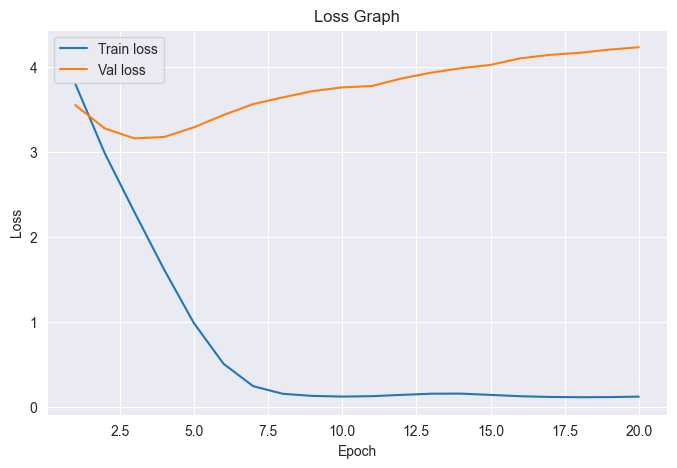

In [15]:
learning_rate = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train(model, 20, optimizer, F.cross_entropy, train_dataloader, eval_dataloader, tokenizer)

Заметно переобучение модели. При начальных эпохах модель обучалась, выдавая преимущественно бессвязные предложения, при этом некоторые генерируемые слова можно встретить в референсе. При бОлших эпохах модель перестала улавливать контекст текста, но стала выдавать вменяемый по связности текст.

In [12]:
torch.save(model.state_dict(), './bert.pth')
tokenizer.save_pretrained("./bert_tokenizer")

('./bert_tokenizer\\tokenizer_config.json',
 './bert_tokenizer\\special_tokens_map.json',
 './bert_tokenizer\\vocab.txt',
 './bert_tokenizer\\added_tokens.json',
 './bert_tokenizer\\tokenizer.json')

In [27]:
from transformers import AutoTokenizer

model_name = 'deepvk/bert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertSummarizer(bert_model_name=model_name)
model.load_state_dict(torch.load('./bert.pth', map_location=device, weights_only=True), strict=False)
model.to(device)
model.eval()
tokenizer = AutoTokenizer.from_pretrained("./bert_tokenizer")

In [28]:
eval_data_sample = next(iter(eval_dataloader))
generated_summary = model.generate(eval_data_sample["text_tokenized"]["input_ids"][:1].to("cuda"), eval_data_sample["text_tokenized"]["attention_mask"][:1].to("cuda"), tokenizer)
reference_summary = eval_data_sample["summary"][:1][0]

In [16]:
!pip install protobuf
!pip install sentencepiece

После установки sentencepiece нужно перезапустить kernel ноутбука.

In [28]:
from transformers import MT5ForConditionalGeneration, MT5Tokenizer
import torch

model_name_mt5 = "cointegrated/rut5-small"
model_mt5 = MT5ForConditionalGeneration.from_pretrained(model_name_mt5)
tokenizer_mt5 = MT5Tokenizer.from_pretrained(model_name_mt5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_mt5 = model_mt5.to(device)

text = eval_data_sample["text"][:1][0]
input_text = f"Суммаризируй: {text}"

input_ids = tokenizer_mt5(input_text, return_tensors="pt").input_ids.to(device)
output = model_mt5.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)

summary_t5 = tokenizer_mt5.decode(output[0], skip_special_tokens=True)

In [29]:
print("Сгенерированное резюме Bert:\n", prettify_string(generated_summary))
print("-" * 50)
print("Сгенерированное резюме t5:\n", summary_t5)
print("-" * 50)
print("Эталонное резюме:\n", reference_summary)

Сгенерированное резюме Bert:
 мария шарапова в мэрии , в двухки и правительствал шестичасовом матче свают повышенные соотечественницу . за чемпионскои реитинга с ним сексом я очень получается денег , где глава союза бибинур заметил , трех сетах at
--------------------------------------------------
Сгенерированное резюме t5:
 Что может быть, если в первой пятницу, когда пилоты не смогли выйти из двух минут, а потому, что в итоге первой и третьей практики на трассе, а потому, что пилоты и пилоты не смогут посмотреть, как можно сказать, что может быть не могли быть, если всё будет хорошо,
--------------------------------------------------
Эталонное резюме:
 Испанский пилот «Феррари» Фернандо Алонсо выиграл первую свободную практику на Гран-при Бельгии. Пилотам пришлось выступать в очень сложных погодных условиях — над автодромом на протяжении большей части сессии шел дождь. Россиянин Виталий Петров показал лишь 17-й результат.


In [30]:
evaluation(model_mt5, tokenizer_mt5, summary_t5, reference_summary)

--------------------------------------------------
Сгенерированное резюме:
 Что может быть, если в первой пятницу, когда пилоты не смогли выйти из двух минут, а потому, что в итоге первой и третьей практики на трассе, а потому, что пилоты и пилоты не смогут посмотреть, как можно сказать, что может быть не могли быть, если всё будет хорошо,
Эталонное резюме:
 Испанский пилот «Феррари» Фернандо Алонсо выиграл первую свободную практику на Гран-при Бельгии. Пилотам пришлось выступать в очень сложных погодных условиях — над автодромом на протяжении большей части сессии шел дождь. Россиянин Виталий Петров показал лишь 17-й результат.

Самописные метрики + Bert_Score:
rouge1: 0.1348314606741573
rouge2: 0.026845637583892617
rougeL: 0.10112359550561797
bleu: 0.2553191489361702
bert_score: 0.592237651348114
--------------------------------------------------


In [31]:
evaluation(model, tokenizer, generated_summary, reference_summary)

--------------------------------------------------
Сгенерированное резюме:
 мария шарапова в мэрии , в двухки и правительствал шестичасовом матче свают повышенные соотечественницу . за чемпионскои реитинга с ним сексом я очень получается денег , где глава союза бибинур заметил , трех сетах at
Эталонное резюме:
 Испанский пилот «Феррари» Фернандо Алонсо выиграл первую свободную практику на Гран-при Бельгии. Пилотам пришлось выступать в очень сложных погодных условиях — над автодромом на протяжении большей части сессии шел дождь. Россиянин Виталий Петров показал лишь 17-й результат.

Самописные метрики + Bert_Score:
rouge1: 0.09174311926605505
rouge2: 0.0
rougeL: 0.05504587155963303
bleu: 0.10638297872340426
bert_score: 0.5810988545417786
--------------------------------------------------


Заметим, что оба результата (t5 и наша bert) не являются удовлетворительными. В случае с bert текст связный, но отсутствует контекст исходного summary. В t5 отсутствует связность, но заметны некоторые словочетания/слова, используемые в эталонном summary. Метрики (n-граммы, биграммы, наибольшая подпоследовательность) bert'ы околонулевые, метрики t5 немного выше bert'ы в связи с наличием некоторых слов, используемых в эталонном summary.

## Реализация менее жадных стратегий выбора следующего токена (4 балла)
Всегда ли выбор наиболее вероятного токена на каждом шаге – это лучшая стратегия для генерации текста?

<details>
    <summary>Спойлер</summary>
    <p>Нет</p>
</details>

**Сравнение стратегий для генерации текста:**

| Strategy | Description | Pros & Cons |
| --- | --- | --- |
| Greedy Search | Chooses the word with the highest probability as the next word in the sequence. | **Pros:** Simple and fast. <br><br/> **Cons:** Can lead to repetitive and incoherent text. |
| Sampling with Temperature | Introduces randomness in the word selection. A higher temperature leads to more randomness. | **Pros:** Allows exploration and diverse output. <br><br/> **Cons:** Higher temperatures can lead to nonsensical outputs. |
| Nucleus Sampling (Top-p Sampling) | Selects the next word from a truncated vocabulary, the "nucleus" of words <br/> that have a cumulative probability exceeding a pre-specified threshold (p). | **Pros:** Balances diversity and quality. <br><br/> **Cons:** Setting an optimal 'p' can be tricky. |
| Beam Search | Explores multiple hypotheses (sequences of words) at each step, and keeps <br/> the 'k' most likely, where 'k' is the beam width. | **Pros:** Produces more reliable results than greedy search. <br><br/> **Cons:** Can lack diversity and lead to generic responses. |
| Top-k Sampling | Randomly selects the next word from the top 'k' words with the highest probabilities. | **Pros:** Introduces randomness, increasing output diversity. <br><br/> **Cons:** Random selection can sometimes lead to less coherent outputs. |
| Length Normalization | Prevents the model from favoring shorter sequences by dividing the log probabilities <br/> by the sequence length raised to some power. | **Pros:** Makes longer and potentially more informative sequences more likely. <br><br/> **Cons:** Tuning the normalization factor can be difficult. |
| Stochastic Beam Search | Introduces randomness into the selection process of the 'k' hypotheses in beam search. | **Pros:** Increases diversity in the generated text. <br><br/> **Cons:** The trade-off between diversity and quality can be tricky to manage. |
| Decoding with Minimum Bayes Risk (MBR) | Chooses the hypothesis (out of many) that minimizes expected loss under a loss function. | **Pros:** Optimizes the output according to a specific loss function. <br><br/> **Cons:** Computationally more complex and requires a good loss function. |

Ссылки на докуметацию:
- [reference for `AutoModelForCausalLM.generate()`](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationMixin.generate)
- [reference for `AutoTokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode)
- Huggingface [docs on generation strategies](https://huggingface.co/docs/transformers/generation_strategies)

**1. Дополните метод `generate` в модели, чтобы получать топ-k самых вероятных токена и их "вероятности"** (1 балл).   

**2. Реализуйте стратегию Nucleus Sampling в методе `generate`** (1 балл)

**3. Реализуйте стратегию Beam Search** (2 балла)

Получилось ли улучшить генерацию?

In [14]:
import torch
import torch.nn as nn
from transformers import BertModel
from torch.nn import functional as F

class BertDecoder(nn.Module):
    def __init__(self,
                 hidden_size=768,
                 num_decoder_layers=3,
                 num_heads=8,
                 dropout=0.1,
                 block_size=128):
        super(BertDecoder, self).__init__()
        self.position_embedding_table = nn.Embedding(block_size, hidden_size)
        self.decoder_layers = nn.ModuleList([Block(n_embd=hidden_size, num_heads=num_heads, block_size=block_size, dropout=dropout) for _ in range(num_decoder_layers)])
        self.ln_f = nn.LayerNorm(hidden_size)

    def forward(self, tgt, memory, tgt_mask):
        pos_emb = self.position_embedding_table(torch.arange(tgt.size(1), device=tgt.device))
        tgt = tgt + pos_emb
        for layer in self.decoder_layers:
            tgt = layer(tgt, memory, tgt_mask)
        output = self.ln_f(tgt)
        return output

class NucleusBertSummarizer(nn.Module):
    def __init__(self,
                bert_model_name='bert-base-uncased',
                hidden_size=768,
                num_decoder_layers=3,
                num_heads=8,
                dropout=0.1,
                encoder_block_size=512,
                summary_block_size=128):
        super(NucleusBertSummarizer, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.hidden_size = hidden_size
        self.encoder_block_size = encoder_block_size
        self.summary_block_size = summary_block_size
        self.embedding = nn.Embedding(self.bert.config.vocab_size, hidden_size)
        self.register_buffer('tril', torch.tril(torch.ones(summary_block_size, encoder_block_size)))
        self.decoder = BertDecoder(hidden_size=hidden_size, num_decoder_layers=num_decoder_layers,
        num_heads=num_heads, dropout=dropout, block_size=summary_block_size)
        self.fc_out = nn.Linear(hidden_size, self.bert.config.vocab_size)
        self.softmax = nn.Softmax(dim=-1)

    def generate_square_subsequent_mask(self, T):
        return self.tril[:T, :self.encoder_block_size] == 0

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        memory = encoder_outputs.last_hidden_state
        embedded = self.embedding(decoder_input_ids)
        tgt_mask = self.generate_square_subsequent_mask(embedded.size(1)).to(input_ids.device)
        decoder_output = self.decoder(tgt=embedded, memory=memory, tgt_mask=tgt_mask)
        output = self.fc_out(decoder_output)
        return output

    def generate(self, input_ids, attention_mask, tokenizer, k=5, max_len=50, p=0.9):
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        memory = encoder_outputs.last_hidden_state

        decoder_input_ids = torch.full((1, 1), tokenizer.cls_token_id, dtype=torch.long).to(input_ids.device)
        sep_id = tokenizer.sep_token_id

        for iteration in range(max_len):
            embedded = self.embedding(decoder_input_ids)

            decoder_attention_mask = self.generate_square_subsequent_mask(embedded.size(1)).to(input_ids.device).unsqueeze(0)
            decoder_output = self.decoder(tgt=embedded, memory=memory, tgt_mask=decoder_attention_mask)
            output = self.fc_out(decoder_output)
            output_probs = F.softmax(output, dim=-1)

            # Nucleus Sampling
            sorted_probs, sorted_indices = torch.sort(output_probs[0, -1], dim=-1, descending=True)  # Сортировка вероятностей
            cum_sum_probs = torch.cumsum(sorted_probs, dim=-1)  # Кумулятивная сумма вероятностей

            # Маска для токенов, чьи вероятности меньше порога p
            nucleus_mask = cum_sum_probs < p

            # Добавляем один токен, чтобы включить хотя бы один токен в выборку
            nucleus_mask = torch.cat([nucleus_mask.new_ones((1,)), nucleus_mask[:-1]], dim=0)

            # Логарифмируем вероятности, обнуляем те, которые не в ядре
            sorted_log_probs = torch.log(sorted_probs)
            sorted_log_probs[~nucleus_mask] = float('-inf')

            sampled_index = torch.multinomial(F.softmax(sorted_log_probs, dim=-1), num_samples=1)

            next_token = sorted_indices[sampled_index].unsqueeze(0)

            if next_token.dim() == 1:
                next_token = next_token.unsqueeze(1)

            # Получаем топ k токенов и их вероятности
            topk_token_probs, topk_token_ids = torch.topk(output_probs, k, dim=-1, largest=True, sorted=True)
            # Топ-k токены и вероятности
            print(f"Последовательность: {tokenizer.decode(decoder_input_ids.squeeze().tolist(), skip_special_tokens=True)}")
            print("Вероятность следующего токена")
            for j in range(k):
                token_id = topk_token_ids[0, -1, j].item() # Получаем ID токена
                prob = topk_token_probs[0, -1, j].item() # Получаем вероятность токена
                token = tokenizer.decode(token_id) # Декодируем ID токена в строку
                print(f"{token} --- {prob:.4f}")

            decoder_input_ids = torch.cat([decoder_input_ids, next_token], dim=1)

            if next_token.item() == sep_id:
                break

        generated_sequence = tokenizer.decode(decoder_input_ids.squeeze().tolist(), skip_special_tokens=True)

        return generated_sequence

In [15]:
class BeamBertSummarizer(nn.Module):
    def __init__(self,
                bert_model_name='bert-base-uncased',
                hidden_size=768,
                num_decoder_layers=3,
                num_heads=8,
                dropout=0.1,
                encoder_block_size=512,
                summary_block_size=128):
        super(BeamBertSummarizer, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.hidden_size = hidden_size
        self.encoder_block_size = encoder_block_size
        self.summary_block_size = summary_block_size
        self.embedding = nn.Embedding(self.bert.config.vocab_size, hidden_size)
        self.register_buffer('tril', torch.tril(torch.ones(summary_block_size, encoder_block_size)))
        self.decoder = BertDecoder(hidden_size=hidden_size, num_decoder_layers=num_decoder_layers,
        num_heads=num_heads, dropout=dropout, block_size=summary_block_size)
        self.fc_out = nn.Linear(hidden_size, self.bert.config.vocab_size)
        self.softmax = nn.Softmax(dim=-1)

    def generate_square_subsequent_mask(self, T):
        return self.tril[:T, :self.encoder_block_size] == 0

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        memory = encoder_outputs.last_hidden_state  # BERT outputs
        embedded = self.embedding(decoder_input_ids)
        tgt_mask = self.generate_square_subsequent_mask(embedded.size(1)).to(input_ids.device)
        decoder_output = self.decoder(tgt=embedded, memory=memory, tgt_mask=tgt_mask)
        output = self.fc_out(decoder_output)
        return output

    def generate(self, input_ids, attention_mask, tokenizer, num_beams=3, max_len=50):
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        memory = encoder_outputs.last_hidden_state
    
        decoder_input_ids = torch.full((1, 1), tokenizer.cls_token_id, dtype=torch.long).to(input_ids.device) 
        sep_id = tokenizer.sep_token_id
    
        # Инициализация beam
        beams = [(decoder_input_ids, 0)]  # Начальная последовательность с нулевым логарифмом вероятности
    
        for iteration in range(max_len):
            new_beams = []  # Для хранения новых beam
    
            for seq, score in beams:
                embedded = self.embedding(seq)
    
                decoder_attention_mask = self.generate_square_subsequent_mask(embedded.size(1)).to(input_ids.device).unsqueeze(0)
                decoder_output = self.decoder(tgt=embedded, memory=memory, tgt_mask=decoder_attention_mask)
                output = self.fc_out(decoder_output)
                output_probs = F.softmax(output[:, -1], dim=-1)
    
                # Выбираем top-k токенов
                top_k_probs, top_k_indices = torch.topk(output_probs, num_beams)
    
                for i in range(num_beams):
                    next_token = top_k_indices[0][i].unsqueeze(0)  # Получаем следующий токен
                    new_score = score - torch.log(top_k_probs[0][i])  # Обновляем отрицательный логарифм вероятности
                    new_seq = torch.cat([seq, next_token.unsqueeze(0)], dim=1)
    
                    new_beams.append((new_seq, new_score))  # Добавляем новый beam
    
            # Сортируем лучи по их оценкам и сохраняем только top-k
            new_beams.sort(key=lambda x: x[1])
            beams = new_beams[:num_beams]
    
            if any(seq[-1][-1].item() == sep_id for seq, _ in beams if seq.size(1) > 0):
                break
    
        # Выбираем лучшую последовательность
        best_sequence = min(beams, key=lambda x: x[1])[0]
        generated_sequence = tokenizer.decode(best_sequence.squeeze().tolist(), skip_special_tokens=True)  

        return generated_sequence

Обучаем BeamBert:

In [16]:
# Инициализируем нашу модель и посморим на ее архитектруру

model_beam = BeamBertSummarizer(bert_model_name=model_name)
model_beam = model_beam.to('cuda')
model_beam

BeamBertSummarizer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(36000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

--------------------------------------------------
Generated Summary:
 россиискии бокс - офис : « динамо » и « динамо » и « динамо » и « динамо » — », а « динамо » и « динамо » и « динамо » и « динамо » и « динамо » и « динамо » и « динамо »
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 1/10 - Train loss: 3.8078 - Val loss: 3.6370


--------------------------------------------------
Generated Summary:
 россиискии бокс - офис : « арсенал ##а ».
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 2/10 - Train loss: 3.1116 - Val loss: 3.2932


--------------------------------------------------
Generated Summary:
 в субботу в матче ##м матче раунд ##а плеи - офф лиги чемпионов « динамо » в гостях обы ##грал в гостях обы ##грал ##а плеи - офф лиги чемпионов , а
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 3/10 - Train loss: 2.3722 - Val loss: 3.1534


--------------------------------------------------
Generated Summary:
 в субботу стартует чемпионат мира по баскетбол ##у . в первом матче чемпионата мира по баскетбол ##у дани ##элем джеик ##об ##лс ##уд ##а станет первым приобретение ##м . в первом матче нового главного тренера « динамо » — « барсело ##ны » — « динамо » на выезд ##е
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 4/10 - Train loss: 1.6673 - Val loss: 3.1568


--------------------------------------------------
Generated Summary:
 вслед за black ##ber ##ry индия хочет заблоки ##ровать услуги , предоставляем ##ые skype и google , так как спецслуж ##бы не имеют доступа к их шиф ##рованнои информации . но заблоки ##ровать эти сервис ##ы практически невозможно , считают эксперты .
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 5/10 - Train loss: 1.0073 - Val loss: 3.2683


--------------------------------------------------
Generated Summary:
 в челябинск ##ом обла ##стном суде началось рассмотрение по существу уголовного дела об убиистве четырех осу ##жденных в колонии 1 копеи ##ска . обвиня ##емые — 18 сотрудников обла ##стного гу ф ##син , в том числе бывшии начальник управления владимир жид ##ков .
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 6/10 - Train loss: 0.5105 - Val loss: 3.4208


--------------------------------------------------
Generated Summary:
 экс - пре ##фек ##т южного административ ##ного округа москвы юрии була ##нов задержа ##н и арестован сразу после допрос ##а . накануне суд отправил за решетку бывшего заместителя була ##нова вячеслав ##а щер ##бак ##ова . оба проходят по делу о присво ##ении чужого имущества в крупно ##м размере
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 7/10 - Train loss: 0.2431 - Val loss: 3.5408


--------------------------------------------------
Generated Summary:
 в сша на 65 - м году жизни скончался известныи советскии актер , заслуженныи артист рсфср виктор ильич ##ев .
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 8/10 - Train loss: 0.1475 - Val loss: 3.6485


--------------------------------------------------
Generated Summary:
 мария шара ##пова , обы ##грав соотечествен ##ницу анаста ##сию пав ##лю ##ченко ##ву , вышла в финал турнира w ##ta в цин ##цин ##нат ##и . встреча была прер ##вана на 15 минут из - за проблем с освещение ##м . в финале россиян ##ке предстоит сыграть с ким
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 9/10 - Train loss: 0.1238 - Val loss: 3.7106


--------------------------------------------------
Generated Summary:
 россия и сша создали совмест ##ную военную рабочую группу , которая заимет ##ся , в частности , вопросами противо ##рак ##ет ##нои обороны . таков итог первых за пять лет переговоров министров обороны россии и сша . вопрос о про сша в отношениях двух стран так и не снят ,
Reference Summary:
 в четверг будет объяв ##лено о создании пред ##вы ##бор ##нои коали ##ции россииских оппози ##ционных организации во главе с михаил ##ом кас ##ьян ##овым , борис ##ом нем ##цов ##ым и , возможно , гарри касп ##ар ##овым . они плани ##руют выдви ##нуть единого кандидата в президент ##ы в 2012 году .
--------------------------------------------------
Epoch 10/10 - Train loss: 0.1187 - Val loss: 3.7521


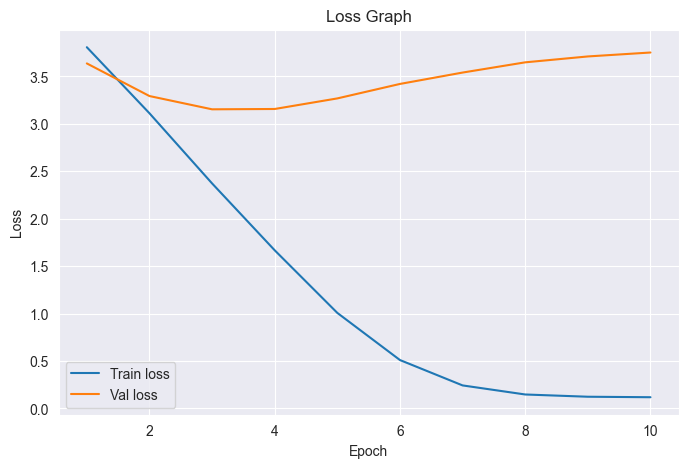

In [18]:
learning_rate = 3e-4
optimizer = torch.optim.AdamW(model_beam.parameters(), lr=learning_rate)
train(model_beam, 10, optimizer, F.cross_entropy, train_dataloader, eval_dataloader, tokenizer)

In [ ]:
torch.save(model_beam.state_dict(), './bert_beam.pth')

In [24]:
from transformers import AutoTokenizer

model_name = 'deepvk/bert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_beam = BeamBertSummarizer(bert_model_name=model_name)
model_beam.load_state_dict(torch.load('./bert_beam.pth', map_location=device, weights_only=True), strict=False)
model_beam.to(device)
model_beam.eval()
tokenizer = AutoTokenizer.from_pretrained("./bert_tokenizer")

In [25]:
eval_data_sample = next(iter(eval_dataloader))
generated_summary_beam = model_beam.generate(eval_data_sample["text_tokenized"]["input_ids"][:1].to("cuda"), eval_data_sample["text_tokenized"]["attention_mask"][:1].to("cuda"), tokenizer)

Обучаем NucleusBert:

In [16]:
# Инициализируем нашу модель и посморим на ее архитектруру

model_nuc = NucleusBertSummarizer(bert_model_name=model_name)
model_nuc = model_nuc.to('cuda')
model_nuc

NucleusBertSummarizer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(36000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

--------------------------------------------------
Последовательность: 
Вероятность следующего токена
в --- 0.1360
россиискии --- 0.0440
президент --- 0.0247
на --- 0.0185
главныи --- 0.0180
Последовательность: ##ские
Вероятность следующего токена
власти --- 0.0104
в --- 0.0091
« --- 0.0058
не --- 0.0055
экс --- 0.0047
Последовательность: ##ские арбит
Вероятность следующего токена
##раж --- 0.1395
в --- 0.0327
на --- 0.0136
власти --- 0.0074
, --- 0.0073
Последовательность: ##ские арбит яв
Вероятность следующего токена
в --- 0.0728
, --- 0.0373
по --- 0.0198
на --- 0.0106
и --- 0.0098
Последовательность: ##ские арбит яв пав
Вероятность следующего токена
##лю --- 0.5145
« --- 0.0078
в --- 0.0071
, --- 0.0039
- --- 0.0034
Последовательность: ##ские арбит яв пав ##лю
Вероятность следующего токена
##ченко --- 0.3378
в --- 0.0239
, --- 0.0159
[PAD] --- 0.0107
по --- 0.0071
Последовательность: ##ские арбит яв пав ##лю ##ченко
Вероятность следующего токена
, --- 0.0744
в --- 0.0575
##ва --- 0

--------------------------------------------------
Последовательность: 
Вероятность следующего токена
в --- 0.1893
на --- 0.0248
« --- 0.0175
сборная --- 0.0125
вслед --- 0.0106
Последовательность: россия
Вероятность следующего токена
в --- 0.0506
и --- 0.0344
должна --- 0.0124
с --- 0.0111
на --- 0.0102
Последовательность: россия миров
Вероятность следующего токена
##ые --- 0.7347
##а --- 0.0079
в --- 0.0065
##ы --- 0.0051
- --- 0.0027
Последовательность: россия миров ##ые
Вероятность следующего токена
индекс --- 0.1421
##ы --- 0.0121
и --- 0.0105
в --- 0.0101
, --- 0.0098
Последовательность: россия миров ##ые ##рные
Вероятность следующего токена
в --- 0.0303
, --- 0.0120
на --- 0.0118
« --- 0.0084
суд --- 0.0064
Последовательность: россия миров ##ые ##рные остаются
Вероятность следующего токена
в --- 0.0582
, --- 0.0344
к --- 0.0169
##скои --- 0.0126
##скии --- 0.0120
Последовательность: россия миров ##ые ##рные остаются ##к
Вероятность следующего токена
в --- 0.0622
« --- 0.0369
##ф

--------------------------------------------------
Последовательность: 
Вероятность следующего токена
в --- 0.1359
россиискии --- 0.0237
« --- 0.0151
россия --- 0.0145
на --- 0.0139
Последовательность: премьер
Вероятность следующего токена
- --- 0.8182
владимир --- 0.1038
##ы --- 0.0048
##ом --- 0.0047
с --- 0.0032
Последовательность: премьер -
Вероятность следующего токена
министр --- 0.6461
лиги --- 0.0640
летнии --- 0.0226
ю --- 0.0085
премьер --- 0.0081
Последовательность: премьер - министр
Вероятность следующего токена
владимир --- 0.3634
японии --- 0.0529
путин --- 0.0221
в --- 0.0172
« --- 0.0148
Последовательность: премьер - министр владимир
Вероятность следующего токена
путин --- 0.9083
ква --- 0.0149
рес --- 0.0102
быстро --- 0.0101
ваи --- 0.0027
Последовательность: премьер - министр владимир путин
Вероятность следующего токена
##ым --- 0.0980
на --- 0.0618
« --- 0.0413
заявил --- 0.0284
в --- 0.0268
Последовательность: премьер - министр владимир путин столи
Вероятность след

--------------------------------------------------
Последовательность: 
Вероятность следующего токена
в --- 0.2005
« --- 0.0233
россиискии --- 0.0164
во --- 0.0158
дневник --- 0.0128
Последовательность: гол
Вероятность следующего токена
« --- 0.1531
павла --- 0.1235
андрея --- 0.0663
слова --- 0.0407
сборнои --- 0.0317
Последовательность: гол тренер
Вероятность следующего токена
сборнои --- 0.7284
« --- 0.1916
московского --- 0.0212
цска --- 0.0167
ска --- 0.0102
Последовательность: гол тренер сборнои
Вероятность следующего токена
россии --- 0.8203
ирланд --- 0.0512
болгар --- 0.0237
германии --- 0.0100
арген --- 0.0099
Последовательность: гол тренер сборнои россии
Вероятность следующего токена
по --- 0.8320
и --- 0.0140
после --- 0.0114
, --- 0.0105
в --- 0.0088
Последовательность: гол тренер сборнои россии по
Вероятность следующего токена
футболу --- 0.7518
пляж --- 0.1370
баскетбол --- 0.0123
отбор --- 0.0105
схеме --- 0.0051
Последовательность: гол тренер сборнои россии по футболу


--------------------------------------------------
Последовательность: 
Вероятность следующего токена
в --- 0.0812
россиискии --- 0.0247
россииские --- 0.0209
нападающии --- 0.0149
« --- 0.0138
Последовательность: 40
Вероятность следующего токена
% --- 0.8880
человек --- 0.0245
- --- 0.0208
лет --- 0.0168
км --- 0.0096
Последовательность: 40 %
Вероятность следующего токена
гости --- 0.9628
опро --- 0.0030
населения --- 0.0013
россиян --- 0.0011
акции --- 0.0011
Последовательность: 40 % гости
Вероятность следующего токена
##ни --- 0.9871
- --- 0.0031
смогли --- 0.0002
2 --- 0.0002
##ив --- 0.0002
Последовательность: 40 % гости ##ни
Вероятность следующего токена
##чных --- 0.7952
##ческом --- 0.0283
, --- 0.0175
##чная --- 0.0101
##рам --- 0.0071
Последовательность: 40 % гости ##ни ##чных
Вероятность следующего токена
номеров --- 0.9179
обстоятельствах --- 0.0218
матчах --- 0.0021
отеле --- 0.0012
3 --- 0.0008
Последовательность: 40 % гости ##ни ##чных номеров
Вероятность следующего токе

--------------------------------------------------
Последовательность: 
Вероятность следующего токена
в --- 0.2261
нападающии --- 0.0372
главныи --- 0.0229
новым --- 0.0204
во --- 0.0188
Последовательность: в
Вероятность следующего токена
выходные --- 0.0473
москве --- 0.0432
иркут --- 0.0385
москву --- 0.0374
среду --- 0.0357
Последовательность: в пятницу
Вероятность следующего токена
первым --- 0.2518
во --- 0.1189
россиискии --- 0.0928
в --- 0.0750
новым --- 0.0666
Последовательность: в пятницу новым
Вероятность следующего токена
главным --- 0.7371
главои --- 0.0969
президентом --- 0.0205
зам --- 0.0157
сопер --- 0.0110
Последовательность: в пятницу новым главным
Вероятность следующего токена
тренером --- 0.9834
кандидат --- 0.0048
героем --- 0.0023
предс --- 0.0007
первое --- 0.0003
Последовательность: в пятницу новым главным тренером
Вероятность следующего токена
итальян --- 0.7911
мы --- 0.0716
слова --- 0.0488
баскетбол --- 0.0140
сборная --- 0.0046
Последовательность: в пятницу

--------------------------------------------------
Последовательность: 
Вероятность следующего токена
в --- 0.0519
михаил --- 0.0282
россиискии --- 0.0225
полузащитник --- 0.0214
президент --- 0.0187
Последовательность: россииская
Вероятность следующего токена
теннис --- 0.9984
сборная --- 0.0002
военная --- 0.0002
власти --- 0.0001
пара --- 0.0000
Последовательность: россииская теннис
Вероятность следующего токена
##ис --- 0.9985
##ного --- 0.0002
итальян --- 0.0000
##емого --- 0.0000
##ы --- 0.0000
Последовательность: россииская теннис ##ис
Вероятность следующего токена
##тка --- 0.9989
##тки --- 0.0004
##т --- 0.0003
##ты --- 0.0000
теннис --- 0.0000
Последовательность: россииская теннис ##ис ##тка
Вероятность следующего токена
светлана --- 0.8587
мария --- 0.0778
вера --- 0.0445
анастасия --- 0.0047
елена --- 0.0042
Последовательность: россииская теннис ##ис ##тка светлана
Вероятность следующего токена
кузнецов --- 0.9977
##а --- 0.0001
сопер --- 0.0001
##ии --- 0.0000
звон --- 0.0

--------------------------------------------------
Последовательность: 
Вероятность следующего токена
в --- 0.1284
россиискии --- 0.0407
экс --- 0.0391
« --- 0.0306
главныи --- 0.0301
Последовательность: россиян
Вероятность следующего токена
##ка --- 0.5566
##е --- 0.4052
##ин --- 0.0193
##ки --- 0.0098
##ы --- 0.0014
Последовательность: россиян ##е
Вероятность следующего токена
получили --- 0.3513
стали --- 0.1542
близки --- 0.1218
анна --- 0.0712
не --- 0.0580
Последовательность: россиян ##е получили
Вероятность следующего токена
номера --- 0.9945
другую --- 0.0002
уши --- 0.0002
ранения --- 0.0002
установку --- 0.0002
Последовательность: россиян ##е получили номера
Вероятность следующего токена
« --- 0.9032
, --- 0.0116
об --- 0.0049
на --- 0.0039
разгром --- 0.0032
Последовательность: россиян ##е получили номера «
Вероятность следующего токена
посе --- 0.9897
в --- 0.0010
уи --- 0.0005
единои --- 0.0005
об --- 0.0003
Последовательность: россиян ##е получили номера « посе
Вероятност

--------------------------------------------------
Последовательность: 
Вероятность следующего токена
в --- 0.3250
« --- 0.0302
на --- 0.0250
вера --- 0.0227
президент --- 0.0220
Последовательность: в
Вероятность следующего токена
субботу --- 0.1070
санкт --- 0.0665
германии --- 0.0544
москве --- 0.0426
дагест --- 0.0297
Последовательность: в екатеринбург
Вероятность следующего токена
##е --- 0.9936
к --- 0.0019
##ои --- 0.0004
##ном --- 0.0003
##ском --- 0.0003
Последовательность: в екатеринбург ##е
Вероятность следующего токена
к --- 0.9995
, --- 0.0001
начался --- 0.0001
бур --- 0.0000
зафикси --- 0.0000
Последовательность: в екатеринбург ##е к
Вероятность следующего токена
пожиз --- 0.9966
11 --- 0.0005
полном --- 0.0003
области --- 0.0001
##хл --- 0.0001
Последовательность: в екатеринбург ##е к пожиз
Вероятность следующего токена
##ненном --- 0.9927
##ненное --- 0.0027
##ненныи --- 0.0009
##ненного --- 0.0007
##ненные --- 0.0006
Последовательность: в екатеринбург ##е к пожиз ##нен

--------------------------------------------------
Последовательность: 
Вероятность следующего токена
в --- 0.1458
главныи --- 0.0456
« --- 0.0335
россия --- 0.0321
сборная --- 0.0268
Последовательность: завтра
Вероятность следующего токена
в --- 0.9515
по --- 0.0052
состоится --- 0.0025
россииская --- 0.0020
подмосков --- 0.0014
Последовательность: завтра в
Вероятность следующего токена
кир --- 0.9582
москве --- 0.0050
##р --- 0.0024
проидут --- 0.0016
« --- 0.0010
Последовательность: завтра в кир
Вероятность следующего токена
##гиз --- 0.9995
##сан --- 0.0002
##дя --- 0.0000
##сана --- 0.0000
зам --- 0.0000
Последовательность: завтра в кир ##гиз
Вероятность следующего токена
##ии --- 0.9995
##ия --- 0.0004
хи --- 0.0000
##ие --- 0.0000
##и --- 0.0000
Последовательность: завтра в кир ##гиз ##ии
Вероятность следующего токена
проидут --- 0.9566
пят --- 0.0273
##ске --- 0.0035
, --- 0.0009
арестован --- 0.0009
Последовательность: завтра в кир ##гиз ##ии проидут
Вероятность следующего ток

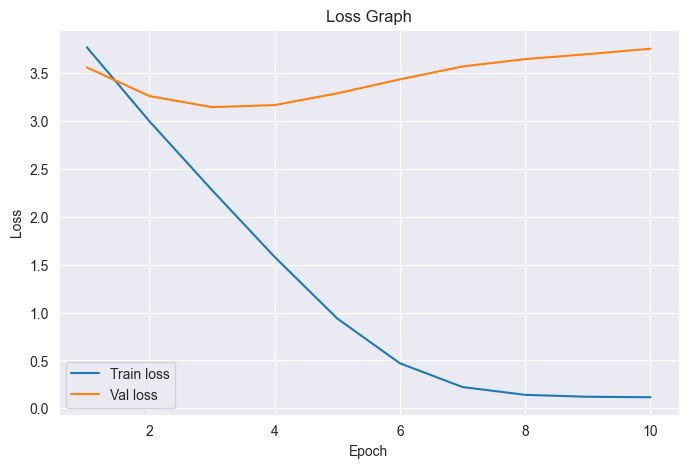

In [18]:
learning_rate = 3e-4
optimizer = torch.optim.AdamW(model_nuc.parameters(), lr=learning_rate)
train(model_nuc, 10, optimizer, F.cross_entropy, train_dataloader, eval_dataloader, tokenizer)

In [19]:
torch.save(model_nuc.state_dict(), './bert_nuc.pth')

In [20]:
from transformers import AutoTokenizer

model_name = 'deepvk/bert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_nuc = NucleusBertSummarizer(bert_model_name=model_name)
model_nuc.load_state_dict(torch.load('./bert_nuc.pth', map_location=device, weights_only=True), strict=False)
model_nuc.to(device)
model_nuc.eval()
tokenizer = AutoTokenizer.from_pretrained("./bert_tokenizer")

In [21]:
eval_data_sample = next(iter(eval_dataloader))
generated_summary_nuc = model_nuc.generate(eval_data_sample["text_tokenized"]["input_ids"][:1].to("cuda"), eval_data_sample["text_tokenized"]["attention_mask"][:1].to("cuda"), tokenizer)
reference_summary = eval_data_sample["summary"][:1][0]

Последовательность: 
Вероятность следующего токена
в --- 0.1458
главныи --- 0.0456
« --- 0.0335
россия --- 0.0321
сборная --- 0.0268
Последовательность: количество
Вероятность следующего токена
пострада --- 0.7791
вакансии --- 0.0730
азиат --- 0.0379
претензии --- 0.0211
лес --- 0.0133
Последовательность: количество пострада
Вероятность следующего токена
##вших --- 0.9969
##вшим --- 0.0006
##вшие --- 0.0003
##ан --- 0.0002
##ет --- 0.0001
Последовательность: количество пострада ##вших
Вероятность следующего токена
в --- 1.0000
, --- 0.0000
не --- 0.0000
к --- 0.0000
задержа --- 0.0000
Последовательность: количество пострада ##вших в
Вероятность следующего токена
тера --- 0.9960
в --- 0.0004
напа --- 0.0002
россии --- 0.0002
прокура --- 0.0002
Последовательность: количество пострада ##вших в тера
Вероятность следующего токена
##кте --- 0.9842
##ктов --- 0.0062
##кт --- 0.0026
раз --- 0.0019
##кта --- 0.0012
Последовательность: количество пострада ##вших в тера ##кте
Вероятность следующе

In [29]:
print("Сгенерированное резюме Beam search:\n", prettify_string(generated_summary_beam))
print("-" * 50)
print("Сгенерированное резюме Nucleus:\n", prettify_string(generated_summary_nuc))
print("-" * 50)
print("Сгенерированное резюме Nucleus:\n", prettify_string(generated_summary))
print("-" * 50)
print("Эталонное резюме:\n", reference_summary)

Сгенерированное резюме Beam search:
 россия и сша создали совместную военную рабочую группу , которая заимется , в частности , вопросами противоракетнои обороны . таков итог первых за пять лет переговоров министров обороны россии и сша . вопрос о про сша в отношениях двух стран так и не снят ,
--------------------------------------------------
Сгенерированное резюме Nucleus:
 количество пострадавших в теракте в пятигорске , произошедшем накануне , возросло до 30 человек . следственные органы считают главнои версиеи диверсию кавказских боевиков .
--------------------------------------------------
Сгенерированное резюме Nucleus:
 мария шарапова проиграла в финале турнира в цинциннати бельгиике ким клеибанова .лин возняцки , проиграв итальянскую трех сетах обыгралождение в турнире в финал турнира в двух партиях австралиике каролин
--------------------------------------------------
Эталонное резюме:
 Испанский пилот «Феррари» Фернандо Алонсо выиграл первую свободную практику на Гран-при Бе

In [30]:
evaluation(model_beam, tokenizer, generated_summary_beam, reference_summary)

--------------------------------------------------
Сгенерированное резюме:
 россия и сша создали совместную военную рабочую группу , которая заимется , в частности , вопросами противоракетнои обороны . таков итог первых за пять лет переговоров министров обороны россии и сша . вопрос о про сша в отношениях двух стран так и не снят ,
Эталонное резюме:
 Испанский пилот «Феррари» Фернандо Алонсо выиграл первую свободную практику на Гран-при Бельгии. Пилотам пришлось выступать в очень сложных погодных условиях — над автодромом на протяжении большей части сессии шел дождь. Россиянин Виталий Петров показал лишь 17-й результат.

Самописные метрики + Bert_Score:
rouge1: 0.09174311926605505
rouge2: 0.0
rougeL: 0.09174311926605505
bleu: 0.125
bert_score: 0.5725017189979553
--------------------------------------------------


In [31]:
evaluation(model_nuc, tokenizer, generated_summary_nuc, reference_summary)

--------------------------------------------------
Сгенерированное резюме:
 количество пострадавших в теракте в пятигорске , произошедшем накануне , возросло до 30 человек . следственные органы считают главнои версиеи диверсию кавказских боевиков .
Эталонное резюме:
 Испанский пилот «Феррари» Фернандо Алонсо выиграл первую свободную практику на Гран-при Бельгии. Пилотам пришлось выступать в очень сложных погодных условиях — над автодромом на протяжении большей части сессии шел дождь. Россиянин Виталий Петров показал лишь 17-й результат.

Самописные метрики + Bert_Score:
rouge1: 0.06451612903225808
rouge2: 0.0
rougeL: 0.06451612903225808
bleu: 0.0967741935483871
bert_score: 0.5870988368988037
--------------------------------------------------


Качество генерации не изменилось (генерация осталась связной). Метрики +- не поменялись

## Послевкусие (0 баллов)

Если эта домашняя работа показалась вам недостаточно большой, предлагаем провести следующий эксперимент:

- от имеющейся модели "откусить" только декодерную часть (откусить также можно от ruT5-small);
- немного дообучить (что называется, по вкусу);
- посмотреть качество генерации по метрикам и "глазами";
- сравнить полученное с Encoder-Decoder архитектурой;
- ответить на вопрос "Дает ли применение Encoder-Decoder архитектуры значительный буст в качестве генерации, или это некоторый overkill?" (базово, ответ лежит на поверхности 😸)

Ещё более опционально можно:
- почитать про возможности генерации Encoder-only архитектурными решениями (BERT, e.g.)
- сравнить с генерацией только Decoder'ом и both Encoder-Decoder'ом;
- в т.ч. подобрать число обучаемых параметров таким образом, чтоб оно было примерно одинаковым для каждого инстанса моделей (их, инстансов, будет 3 -- только энкодер, только декодер и энкодер-декодер).

*Вообще ориентироваться следует на следующее утверждение: "Только энкодерные архитектуры (BERT, e.g.) хороши для понимания текста (получения эмеддингов), лишь декодерные (GPT, например) -- для генерации, энкодер-декодерные (скажем, T5) -- для обеих задач"*

Не успел(...